✅ Total images: 5722
class
notumor       1595
pituitary     1467
meningioma    1339
glioma        1321
Name: count, dtype: int64
📊 Train: 3890, Val: 687, Test: 1145
Found 3890 validated image filenames belonging to 4 classes.
Found 687 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 147s 633ms/step - accuracy: 0.5508 - loss: 1.3761 - val_accuracy: 0.2795 - val_loss: 2.2112 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 396ms/step - accuracy: 0.7381 - loss: 0.7354 - val_accuracy: 0.3755 - val_loss: 3.3238 - learning_rate: 0.0010
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - accuracy: 0.7563 - loss: 0.6660 - val_accuracy: 0.2940 - val_loss: 3.7053 - learning_rate: 0.0010
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - accuracy: 0.7840 - loss: 0.5570 - val_accuracy: 0.3450 - val_loss: 2.5234 - learning_rate: 0.0010
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 409ms/step - accuracy: 0.8262 - loss: 0.4922 - val_accuracy: 0.4381 - val_loss: 4.9372 - learning_rate: 0.0010
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 413ms/step - accuracy: 0.8185 - loss: 0.5242 - val_accuracy: 0.6390 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 401ms/step - accuracy: 0.

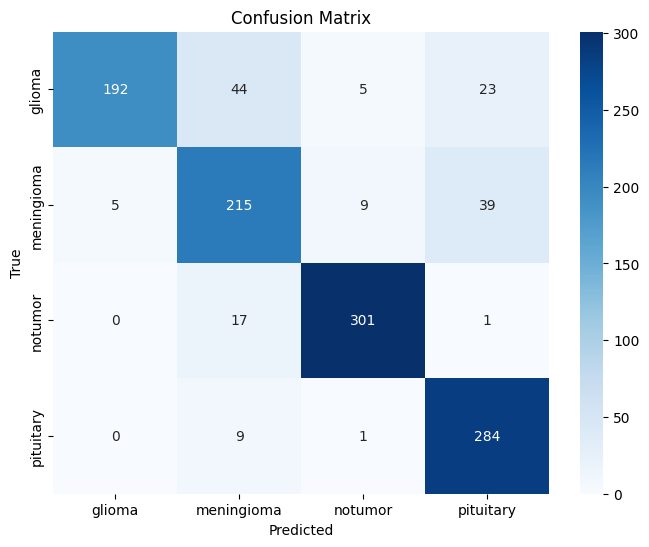

In [12]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns

# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/harvard-medical-dataset/Harvard_medical_dataset/Training"
IMG_SIZE = (224, 224)   # ResNet50 default size
BATCH_SIZE = 32
EPOCHS = 50   # training longer since from scratch

# ✅ Step 3: Load image paths and labels
image_paths, labels = [], []
for class_dir in sorted(os.listdir(DATASET_PATH)):
    class_path = os.path.join(DATASET_PATH, class_dir)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images: {len(df)}")
print(df['class'].value_counts())

# ✅ Step 4: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ✅ Step 5: ImageDataGenerators
train_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                           target_size=IMG_SIZE, class_mode='categorical',
                                           batch_size=BATCH_SIZE)

val_flow = val_test_gen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, class_mode='categorical',
                                            batch_size=BATCH_SIZE)

test_flow = val_test_gen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                             target_size=IMG_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, shuffle=False)

# ✅ Step 6: Build ResNet50 Model (from scratch)
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
num_classes = len(train_flow.class_indices)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 8: Train
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint("best_resnet50_scratch.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=50, verbose=1)
]

history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# ✅ Step 9: Evaluate
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# ✅ Step 10: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ✅ Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
